In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, Convolution2D, Input
from keras import regularizers
from keras.layers.pooling import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.layers import LeakyReLU
from sklearn import preprocessing

from PIL import Image

### Load processed images and create train/dev split

Category:  shovel
(10000, 31)


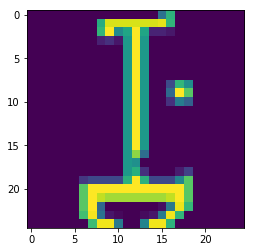

In [24]:
#Load images and labels
images = np.load('data/train_clean.npy',encoding = 'latin1')
newDims = 25
T_text = np.loadtxt('train_labels.csv', usecols=1, delimiter=',', dtype='str')
T_text = T_text[1:]

enc = preprocessing.LabelEncoder()
T = enc.fit_transform(T_text)
T = keras.utils.to_categorical(T)

X = images.reshape(len(images), newDims, newDims)
X = X/255

print('Category: ', T_text[0])
plt.imshow(X[0])

In [25]:
X_train, X_valid, T_train, T_valid = train_test_split(X, T, test_size=0.20, random_state=42)

X_train = X_train.reshape(len(X_train), newDims, newDims, 1)
X_valid = X_valid.reshape(len(X_valid), newDims, newDims, 1)

### Preliminary keras CNN

In [33]:

def createModel():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(newDims,newDims,1)))
    model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))
    
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))
    
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.7))
    model.add(Dense(31, activation='softmax'))
    
    return model

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model1 = createModel()
model1.compile(optimizer=adam , loss='categorical_crossentropy', metrics=['accuracy'])
 
#Weight saving
filepath1 = "weights/weights.hdf5"
#model1.load_weights("weights.hdf5")


checkpoint1 = ModelCheckpoint(filepath1, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'auto')
callbacks_list1 = [checkpoint1] 

#Fit without Data Augmentation
#history = model1.fit(X_train, T_train, batch_size=32, epochs=100, verbose=1, 
#   validation_data=(X_valid, T_valid), shuffle=True, callbacks = callbacks_list1)
 
#model1.evaluate(X_valid, T_valid)


### Data augmentation to combat overfitting 

In [34]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

batch_size = 16

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = False, 
                         width_shift_range = 3,
                         height_shift_range = 3,
                         zoom_range = 0.01,
                         rotation_range = 0
                        )

generator = gen.flow(X_train, T_train, batch_size = batch_size)

history = model1.fit_generator(
    generator,
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                epochs=100,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid, T_valid),
                callbacks = callbacks_list1
)


Epoch 1/100
500/500 [==============================] - 27s 54ms/step - loss: 3.1762 - acc: 0.1726 - val_loss: 2.1633 - val_acc: 0.4015

Epoch 00001: loss improved from inf to 3.17615, saving model to weights/weights.hdf5
Epoch 2/100
500/500 [==============================] - 28s 56ms/step - loss: 2.5817 - acc: 0.2695 - val_loss: 1.9542 - val_acc: 0.4420

Epoch 00002: loss improved from 3.17615 to 2.58165, saving model to weights/weights.hdf5
Epoch 3/100
500/500 [==============================] - 25s 50ms/step - loss: 2.3471 - acc: 0.3334 - val_loss: 1.8273 - val_acc: 0.4590

Epoch 00003: loss improved from 2.58165 to 2.34706, saving model to weights/weights.hdf5
Epoch 4/100
500/500 [==============================] - 25s 51ms/step - loss: 2.1946 - acc: 0.3779 - val_loss: 1.6789 - val_acc: 0.5060

Epoch 00004: loss improved from 2.34706 to 2.19458, saving model to weights/weights.hdf5
Epoch 5/100
500/500 [==============================] - 26s 51ms/step - loss: 2.0772 - acc: 0.4114 - val_

500/500 [==============================] - 27s 53ms/step - loss: 1.1450 - acc: 0.6820 - val_loss: 0.9494 - val_acc: 0.7335

Epoch 00038: loss did not improve from 1.13673
Epoch 39/100
500/500 [==============================] - 24s 48ms/step - loss: 1.1345 - acc: 0.6839 - val_loss: 0.9225 - val_acc: 0.7395

Epoch 00039: loss improved from 1.13673 to 1.13446, saving model to weights/weights.hdf5
Epoch 40/100
500/500 [==============================] - 24s 47ms/step - loss: 1.1146 - acc: 0.6835 - val_loss: 0.9216 - val_acc: 0.7455

Epoch 00040: loss improved from 1.13446 to 1.11463, saving model to weights/weights.hdf5
Epoch 41/100
500/500 [==============================] - 26s 52ms/step - loss: 1.1081 - acc: 0.6869 - val_loss: 0.9366 - val_acc: 0.7340

Epoch 00041: loss improved from 1.11463 to 1.10806, saving model to weights/weights.hdf5
Epoch 42/100
500/500 [==============================] - 25s 50ms/step - loss: 1.1163 - acc: 0.6841 - val_loss: 0.9128 - val_acc: 0.7415

Epoch 00042: l

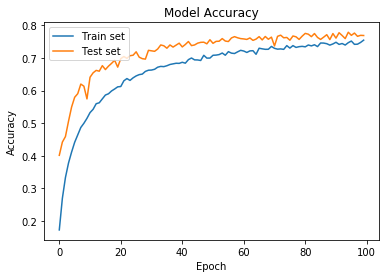

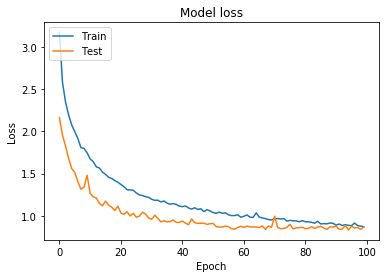

In [36]:
# list all data in history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Test set'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()